In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img = cv2.imread('pers.png', -1)
img = img.astype(np.float32) / 255

[h, w, _] = img.shape
FOV = 80
wFOV = FOV
THETA = -20
PHI = -20
hFOV = float(h) / w * wFOV
width = 1024
height = 512
w_len = np.tan(np.radians(wFOV / 2.0))
h_len = np.tan(np.radians(hFOV / 2.0))

In [3]:
x,y = np.meshgrid(np.linspace(-180, 180,width),np.linspace(90,-90,height))
x_map = np.cos(np.radians(x)) * np.cos(np.radians(y))
y_map = np.sin(np.radians(x)) * np.cos(np.radians(y))
z_map = np.sin(np.radians(y))

xyz = np.stack((x_map,y_map,z_map),axis=2)

In [4]:
y_axis = np.array([0.0, 1.0, 0.0], np.float32)
z_axis = np.array([0.0, 0.0, 1.0], np.float32)
[R1, _] = cv2.Rodrigues(z_axis * np.radians(THETA))
[R2, _] = cv2.Rodrigues(np.dot(R1, y_axis) * np.radians(-PHI))
R1 = np.linalg.inv(R1)
R2 = np.linalg.inv(R2)

In [5]:
xyz = xyz.reshape([height * width, 3]).T
xyz = np.dot(R2, xyz)
xyz = np.dot(R1, xyz).T

In [6]:
xyz = xyz.reshape([height, width, 3])
inverse_mask = np.where(xyz[:,:,0]>0,1,0)
xyz = xyz/np.repeat(xyz[:,:,0][:, :, np.newaxis], 3, axis=2)

In [7]:
lon_map = np.where((-w_len<xyz[:,:,1])&(xyz[:,:,1]<w_len)&(-h_len<xyz[:,:,2])
                    &(xyz[:,:,2]<h_len),(xyz[:,:,1]+w_len)/2/w_len*w,0)
lat_map = np.where((-w_len<xyz[:,:,1])&(xyz[:,:,1]<w_len)&(-h_len<xyz[:,:,2])
                    &(xyz[:,:,2]<h_len),(-xyz[:,:,2]+h_len)/2/h_len*h,0)
mask = np.where((-w_len<xyz[:,:,1])&(xyz[:,:,1]<w_len)&(-h_len<xyz[:,:,2])
                    &(xyz[:,:,2]<h_len),1,0)

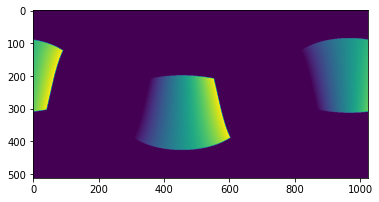

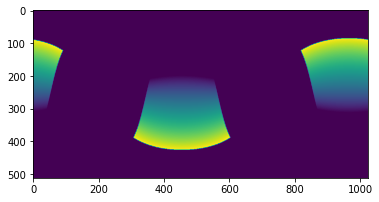

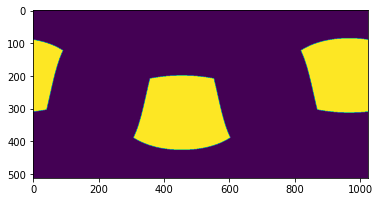

In [8]:
plt.imshow(lon_map)
plt.show()
plt.imshow(lat_map)
plt.show()
plt.imshow(mask)
plt.show()

In [9]:
equi = cv2.remap(img, lon_map.astype(np.float32), lat_map.astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)

In [10]:
mask = mask * inverse_mask
mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
equi = equi * mask

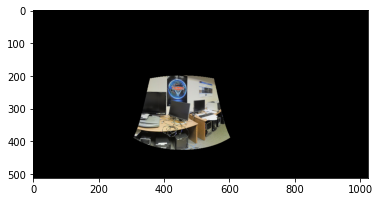

In [11]:
equi_int = (equi * 255).astype(np.uint8)
plt.imshow(equi_int[:,:,[2,1,0]])
plt.show()